# Explore Kentucky Lidar Data 

![UKy's central campus in lidar point cloud](https://nyc3.digitaloceanspaces.com/astoria/geo409/images/lidar-banner.jpg)     
*UKy's central campus in lidar point cloud*


This notebook will create a download and extract LAZ files and create LAS datasets. It will colorize the point cloud from an RGB image from the ImageServices service hosted on the KyRaster.Ky.gov ArcGIS Server and create raster derivatives for 3D visualizations. Please follow the steps in our lesson  [readme.md](../README.md#application-exploring-kentucky-in-3d) before using this notebook.

### Before you start
* Check your root GIS and make you know it's location. E.g., `d:\\BoydsGIS` and note the double backslashes.
* Make sure you have downloaded the [tools.zip](https://nyc3.digitaloceanspaces.com/astoria/geo409/tools.zip) file and extracted it to your root GIS folder. Note the location of the folder. E.g., `d:\\BoydsGIS\\tools`.

### Dictionaries and modules in our workflow

This Notebook wraps ArcPy functions and uses Python dictionaries to pass parameters to ArcPy function. A dictionary is a collection of key-value pairs. The key is a string and the value can be any Python object. The dictionary is defined by curly braces `{}`. The key:values are separated by a colon `:`. The key-value pairs, the properties, are separated by a comma `,`. 

#### Code cell

The following cell contains the function definitions and global dictionary used to store project properties. You are invited to experiment with the cell, but please have a backup handy. Otherwise, avoid tinkering in the cell. 

In [1]:
############### Project resources. Do not edit unless you have a backup ;) ###############

# Version 0.3 last modified 2025-03-22
# UKy Geography Department, GEO 409, Spring 2025
# The script is designed to be used in a Jupyter Notebook environment with ArcGIS Pro.

import arcpy
import subprocess
from zipfile import ZipFile
from datetime import datetime
from urllib.request import urlretrieve
import pandas as pd

############### Test functions ###############
def helloLidar(name):
    print(f"Hello {name}! Welcome to the helper functions @ KY lidar processing!")

def helloDictionary(aDict):
    for key, value in aDict.items():
        print(f"{key}: {value}")

############### Project variables and properties ###############
projectTemplate = {}
def buildProjectTemplate (root, folder):
    a = {
        "root": root,
        "folder": folder,
        "project": f'{root}\\{folder}',
        "db": f'{root}\\{folder}\\{folder}.gdb',
        "lidar": f'{root}\\{folder}\\las',
        "download": f'{root}\\{folder}\\laz',
        "lidar phase":"",
        "image year":"",
        "image type":"",
        "EPSG coordinate system":"",
        'raster type from point cloud': "",
        "elevation raster resolution": 5,
        "tools": f'{root}\\tools',
        "laz": f"{root}\\tools\\LAStools\\bin\\laszip64.exe",
        "lasmerge": f"{root}\\tools\\LAStools\\bin\\lasmerge64.exe",
        "grid":  f"{root}\\tools\\grids\\tile-grids.gdb\\KY_5k_LAZ",
        "potree": f"{root}\\tools\\potree\\PotreeConverter.exe",
        "potree2": f"{root}\\tools\\potree2\\PotreeConverter.exe",
        "project description": "Create a point cloud viewer for the area of interest.",
        "author": "",
        "data source": "KentuckyFromAbove.ky.gov and KyRaster.ky.gov",
        'date of project': datetime.now(),
    }
    global projectTemplate
    projectTemplate = a

############### Utility functions ###############

def setWork(p):
    """Create dictionary of path names from project variables 
    and return dot.notation access to dictionary attributes.
    Used internally for shorthand access to path names."""
    class dotdict(dict):
        """dot.notation"""
        __getattr__ = dict.get
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__
    return dotdict(p)

def listContents(root ="", folder=""):
    """Function to print contents of a directory and report time when the cell finished processing.
    listContents(root, folder)
    Two arguments:
        root = drive letter and folder for your root GIS space (string)
        folder = path to folder in root (string)
    """
    p = setWork(projectTemplate)
    if root == "":
        check = p.project
        print(f"Checking {check}...")
    else:
        check = f'{root}\\{folder}'
        print(f"Checking {check}...")
    completed = subprocess.run(f'dir {check}', shell=True, stdout=subprocess.PIPE)
    print(completed.stdout.decode('UTF-8'))

def checkFolder(name):
    """Function to check folder name against special characters for creating project space.
    checkFolder(name)
    One argument:
        name = name of project folder for this application (string)
    """
    special = "\"\' :;\\.!@#$%^&*()-+?=,<>/"
    if any(letter in special for letter in name):
        print("Whoops! You have a special character in your project's name. \nPlease change project name.")
        return False
    else:
        print(f'Checking project folder...')
        return True

def checkToolsFolder():
    p = setWork(projectTemplate)
    print(f"Checking for tools in {p.tools}...")
    completed = subprocess.run(f'dir /B {p.tools}', shell=True, stdout=subprocess.PIPE)
    print(completed.stdout.decode('UTF-8'))
    print("If you see resources, you're food to go! If not, run the downloads folder. Finished processing", datetime.now())

def checkDatabase():
    features = arcpy.ListFeatureClasses()
    print(f"Checking {arcpy.env.workspace} database for features and rasters...")
    for feature in features:
        print(f"Vector layer: {feature}")
    rasters = arcpy.ListRasters()
    for raster in rasters:
        print(f"Raster layer: {raster}")

def finishedProcessing(name):
    print(f"🗸 {name} finished processing", datetime.now())

def time_difference(start, n):
    current_datetime = datetime.now()
    seconds = round((current_datetime - start).total_seconds(), 1)
    minutes = round((n * seconds) / 60, 1)
    if n > 1:
        s = f' With {n} steps remaining: {minutes}m.'
    else:
        s = ''
    print (f"Process took ({seconds}s) to complete.{s}")
    return seconds

    
############### Project Functions ###############

def setUpProject(a):
    """Function to create project folder and database in root GIS.
    setUpProject()
    Arguments are parsed from an options dictionary.
    """
    buildProjectTemplate(a['GIS root'], a['project name'])
    p = setWork(projectTemplate)
    projectTemplate["project description"] = a["project description"]
    projectTemplate["author"] = a["author"]
    projectTemplate["EPSG coordinate system"] = a['output coordinate system']
    arcpy.env.overwriteOutput = a['overwrite output']
    arcpy.env.addOutputsToMap = a['add new data to map']
    arcpy.env.outputCoordinateSystem = arcpy.SpatialReference(a['output coordinate system'])
    if checkFolder(p.folder):
        subprocess.run(f'mkdir {p.project}', shell=True)
        subprocess.run(f'mkdir {p.download}', shell=True)
        subprocess.run(f'mkdir {p.lidar}', shell=True)
    else: 
        print(f"Rerun this cell after changing project name.")
        return
    try:
        test_workspace = arcpy.Describe(p.db)
        if test_workspace.dataType == 'Workspace':
            print(f"Output database already exists: {p.db}")
    except:
        arcpy.management.CreateFileGDB(p.project, p.folder)
        print(f"Created output database: {p.db}")   
    arcpy.env.workspace = p.db
    print(f"Created project folder and database in {p.project}")
    print(f"Using {arcpy.env.workspace} for output")
    print(f"{p.download} for LAZ downloads")
    print(f"{p.lidar} for LAS files")
    print(f"Let's check for tools and grids...")
    checkToolsFolder()
    finishedProcessing("setUpProject")
            
def setAoi(a):
    """Function to create area of interest. The function creates a layer called 'aoi'.
    setAoi()
    Four variables that it uses:
    lat = latitude for center of AOI (number)
    lon = longitude for center of AOI (number)
    buffer = distance, in feet, from center of AOI to include in analysis (number)
    square {optional} = square (default) or circular aoi polygon
    """
    p = setWork(projectTemplate)
    custom_aoi = a['custom aoi']
    lat = a['lat']
    lon = a['lon']
    buffer = a['buffer']
    square = a['square']
    arcpy.env.workspace = p.db
    arcpy.env.extent = 'MAXOF'
    output = 'aoi'
    arcpy.env.addOutputsToMap = False
    if custom_aoi:
        arcpy.management.CopyFeatures(custom_aoi, output)
    else:
        out1 = '_pt_temp'
        out2 = '_ro_temp'
        wgs84 = arcpy.SpatialReference(4326)
        point = arcpy.Point(lon, lat) 
        ptGeometry = arcpy.PointGeometry(point, wgs84)
        arcpy.management.CopyFeatures(ptGeometry, out1)
        if square:
            arcpy.analysis.Buffer(out1, out2, buffer)
            arcpy.management.FeatureEnvelopeToPolygon(out2, output)
            arcpy.management.Delete(out2)
        else:
            arcpy.analysis.Buffer(out1, output, buffer)
        arcpy.management.Delete(out1)
    arcpy.env.extent = output
    print(f"Using {p.db}\\{output} for AOI")
    desc = arcpy.Describe(output)
    print(f'Coordinate system: {desc.spatialReference.name} \n Checking fields...')
    fields = arcpy.ListFields(output)
    for field in fields:
        print(f"{field.name} has a type of {field.type} with a length of {field.length}")
    print(f'Area of interest created in {output}')
    finishedProcessing("setAoi")
    return f'{p.db}\\{output}'

def findLazTiles(a):
    p = setWork(projectTemplate)
    checkDatabase()
    pathToGrid = p.grid
    aoi = a["aoi"]
    arcpy.env.workspace = p.db
    aoilaz = f'{p.db}\\aoilaz'
    arcpy.Intersect_analysis ([aoi, pathToGrid], aoilaz)
    length = int(arcpy.GetCount_management(aoilaz).getOutput(0))
    print (f'Number of tiles to download and process: {length}')
    projectTemplate['number of laz tiles'] = length
    print(f'Grid of LAZ tiles created in aoilaz')
    finishedProcessing("findLazTiles")
    return aoilaz

def checkLazTiles(a):
    p = setWork(projectTemplate)
    checkDatabase()
    pathToGrid = p.grid
    aoilaz = a["grid of laz tiles to download"]
    phase = a['phase']
    arcpy.env.workspace = p.db
    cursor = arcpy.da.SearchCursor(aoilaz, ['TileName', f'Phase{phase}_Box_zip', f'Phase{phase}_Year'])
    missing = 0
    for row in cursor:
        url = row[1]
        if url == None:
            missing += 1
        name = f"{row[0]}_{row[2]}"
        print(url,name)
    print (f'Missing tiles: {missing}')
    finishedProcessing("checkingLazTiles")
    return aoilaz


def convertLaz2las(a):
    """Function to download LAZ files from a grid of URLs and convert them to LAS files.
    convertLaz2las()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    checkDatabase()
    phase = a['phase']
    projectTemplate['lidar phase'] = phase
    laszip = p.laz
    root = p.root
    folder = p.folder
    aoilaz = a["grid of laz tiles to download"]
    length = projectTemplate['number of laz tiles']
    cursor = arcpy.da.SearchCursor(aoilaz, ['TileName', f'Phase{phase}_Box_zip', f'Phase{phase}_Year'])
    i = 1
    allTime = 0
    las_names = []
    for row in cursor:
        url = row[1]
        name = f"{row[0]}_{row[2]}"
        lazout = f'{root}\\{folder}\\laz\\{name}.laz'
        lasout = f'{root}\\{folder}\\las\\{name}.las'
        las_names.append(lasout)
        print(f"Processing {i} of {length}\nDownloading {url}")
        start_time = datetime.now()
        urlretrieve(url, lazout)
        print(f"Converting {lazout} to {lasout}")
        completed = subprocess.run(f'{laszip} -i {lazout} -o {lasout}', shell=True, stdout=subprocess.PIPE)
        print(completed.stdout.decode('UTF-8'))
        allTime += time_difference(start_time, length - i)
        avgTime = round(allTime/i, 1)
        print(f"Average time: {avgTime}s. Estimated time remaining: {round(((length - i) * avgTime)/60, 1)}m")
        i += 1
    print(f"Total time to process: {round(allTime/60, 1)}m")
    finishedProcessing("convertLaz2las")
    return las_names


def createAndExtractLasDataset(a):
    """Function to create LAS dataset from LAS files and extract LAS dataset to a new LAS dataset.
    createAndExtractLasDataset()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    root = p.root
    folder = p.folder
    aoi = a['aoi']
    phase = p["lidar phase"]
    ky = arcpy.SpatialReference(3089)
    lasInput = f"{root}\\{folder}\\las"  
    lasdOutput = f"{root}\\{folder}\\{folder}"
    print(f'Creating LAS dataset for {lasdOutput}')
    las_files = []
    i = 1
    allTime = 0
    subprocess.run(f'dir {lasInput}\\*.las /b > {lasInput}\\las.txt', shell=True, stdout=subprocess.PIPE)
    with open(f'{lasInput}\\las.txt', 'r') as fileList:
        for line in fileList:
            las_name = line.strip()
            las_path = f"{lasInput}\\{las_name}"
            las_files.append(las_path)
            i += 1
    print(f"Number of tiles: {len(las_files)}")
    start_time = datetime.now()
    arcpy.CreateLasDataset_management(las_files, lasdOutput, "#", "#", ky, True, True)
    time_difference(start_time, 1)/60
    finishedProcessing("LasDataset")
    inLasd = f"{root}\\{folder}\\{folder}.lasd"
    outLasd = f"{root}\\{folder}\\{folder}_extract_phase{phase}.lasd"
    outExtractFolder = f'{root}\\{folder}\\extract'
    command = f'rmdir /Q /S {outExtractFolder}'
    subprocess.run(command, shell=True, stdout=subprocess.PIPE)
    subprocess.run(f'mkdir {outExtractFolder}', shell=True, stdout=subprocess.PIPE)
    start_time = datetime.now()
    arcpy.ExtractLas_3d (inLasd, outExtractFolder, "#", aoi,  "#", "_e", "#", "#", True, outLasd)
    time_difference(start_time, 1)/60
    finishedProcessing("ExtractLas")
    return outLasd

def getPointCloudStats(a):
    """Function to get statistics from LAS dataset.
    getPointCloudStats()
    Arguments are parsed from an options dictionary.
    """
    lasdOutput = a['lasd']
    print(f'Using {lasdOutput} for statisitcs.')
    subprocess.run(f'rm {lasdOutput}_stats.csv', shell=True, stdout=subprocess.PIPE)
    subprocess.run(f'rm {lasdOutput}_stats.csv.xml', shell=True, stdout=subprocess.PIPE)
    arcpy.LasDatasetStatistics_management(f"{lasdOutput}", "#", f'{lasdOutput}_stats.csv', "#", "#", "#")
    with open(f'{lasdOutput}_stats.csv', encoding='utf-8') as csv:
        reader = pd.read_csv(csv)
        pdData = pd.DataFrame(reader)
    return pdData[pdData["Category"] == "ClassCodes"]

def extractImageGetProps(a):
    """Function to extract image from raster and get properties.
    extractImageGetProps()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    root = p.root
    folder = p.folder
    image = a['input image']
    out_image = f"{a['input image type']}_{a['year']}"
    aoi = a['aoi']
    projectTemplate['image year'] = a['year']
    projectTemplate['image type'] = a['input image type']
    arcpy.env.extent = aoi 
    start_time = datetime.now()
    arcpy.management.Clip(image, "#", out_image, aoi, "#", "ClippingGeometry")
    arcpy.env.extent = "MAXOF"
    describe = arcpy.Describe(out_image)
    print(describe.bandCount, "bands found in the raster")
    for band in describe.children:
        print(band.name) 
    time_difference(start_time, 1)/60
    finishedProcessing("extractImageGetProps")
    return out_image

def colorizePointCloud(a):
    """Function to colorize point cloud with image.
    colorizePointCloud()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    root = p.root
    folder = p.folder
    phase = p['lidar phase']
    lasd = a['input lasd']
    image = a['input image']
    red = a['Red band']
    green = a['Green band']
    blue = a['Blue band']
    outColorized = f"{root}\\{folder}\\{folder}_colorized_{image}_phase{phase}.lasd"
    outColorizedFolder = f"{root}\\{folder}\\colorized"
    bands = f'RED {red}; GREEN {green}; BLUE {blue}'
    subprocess.run(f'mkdir {outColorizedFolder}', shell=True, stdout=subprocess.PIPE)
    start_time = datetime.now()
    arcpy.ColorizeLas_3d (lasd, image, bands, outColorizedFolder, f"_img_rgb", "#", "#","#", "#", True, outColorized)
    time_difference(start_time, 1)/60
    finishedProcessing("colorizePointCloud")
    return outColorized

def rasterizePointCloud(a):
    """Function to create raster from point cloud.
    rasterizePointCloud()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    root = p.root
    folder = p.folder
    lasd = a['lasd']
    phase = p['lidar phase']
    classCodes = a['class codes']
    resolution = a['cell resolution']
    sample = a['sampling method']
    returns = a['returns']
    rasterType = a['type of raster']
    projectTemplate['raster type from point cloud'] = rasterType
    projectTemplate['elevation raster resolution'] = resolution
    arcpy.env.workspace = p.db
    outputName = f'{rasterType}_phase{phase}_{resolution}ft'
    tempLasd = f"{root}\\{folder}\\{outputName}.lasd"
    arcpy.MakeLasDatasetLayer_management (lasd, tempLasd, classCodes, returns)
    start_time = datetime.now()
    arcpy.LasDatasetToRaster_conversion (tempLasd,  outputName, "#", sample, "#", "#", resolution)
    time_difference(start_time, 1)/60
    finishedProcessing("rasterizePointCloud")
    return outputName

def hillshadePointCloud(a):
    """Function to create shaded relief raster from elevation raster.
    hillshadePointCloud()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    root = p.root
    folder = p.folder
    phase = p['lidar phase']
    rasterType = p['raster type from point cloud']
    resolution = p['elevation raster resolution']
    inputDem = a['elevation raster']
    azimuth = a['azimuth']
    altitude = a['altitude']
    shadows = a['shadows']
    zFactor = a['zFactor']
    arcpy.env.workspace = p.db
    outputName = f'{rasterType}_phase{phase}_{resolution}ft_hillshade'
    start_time = datetime.now()
    arcpy.HillShade_3d(inputDem, outputName, azimuth, altitude, shadows, zFactor)
    time_difference(start_time, 1)/60
    finishedProcessing("hillshadePointCloud")
    return outputName

def mergeLas(a):
    """Function to merge LAS files in a folder to a single LAS file.
    mergeLas()
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    root = p.root
    folder = p.folder
    phase = p['lidar phase']
    las = a['input folder']
    classes = a['keep class codes']
    processing = f"{root}\\{folder}\\{las}"
    merged = f"{root}\\{folder}\\merged"
    mergedLas = f"{root}\\{folder}\\merged\\{folder}_phase{phase}_merged.las"
    start_time = datetime.now()
    subprocess.run(f'rm {mergedLas}', shell=True, stdout=subprocess.PIPE)
    subprocess.run(f'mkdir {merged}', shell=True, stdout=subprocess.PIPE)
    subprocess.run(f'dir {processing}\\"*.las" /b /s > {processing}\\las.txt', shell=True, stdout=subprocess.PIPE)
    subprocess.run(f"{p.lasmerge} -lof {processing}\\las.txt -keep_class {classes} -o {mergedLas}")
    time_difference(start_time, 1)/60
    finishedProcessing("mergeLas")
    return mergedLas

def makeViewer(a):
    """Function run command line tool PotreeConverter to create web browser point cloud viewer.
    makeViewer()
    version = 1 or 2. Potree version to use. Version 1 can be uploaded to GitHub Pages. 
    Version 2 is better, but cannot be hosted on GitHub Pages. (Number)
    Arguments are parsed from an options dictionary.
    """
    p = setWork(projectTemplate)
    project = p.project
    inputLas = a['input merged las name']
    version = a['potree version']
    directory = f"{project}\\viewer"
    start_time = datetime.now()
    if (version == 1):
        subprocess.run(f'rmdir /Q /S {directory}', shell=True, stdout=subprocess.PIPE)
        subprocess.run(f'mkdir {directory}', shell=True)
        subprocess.run(f"{p.potree} {inputLas} -o {directory} --generate-page index")
    else:
        directory = f"{project}\\viewer2"
        subprocess.run(f'rmdir /Q /S {directory}', shell=True, stdout=subprocess.PIPE)
        subprocess.run(f'mkdir {p.project}\\viewer2', shell=True)
        subprocess.run(f"{p.potree2}  -i {inputLas} -o {directory} --generate-page index")
    time_difference(start_time, 1)/60
    finishedProcessing("makeViewer")
    return directory

In [2]:
# Let's see what's in your root GIs folder.
rootFolder = 'd:\\BoydsGIS'
listContents(rootFolder)
# If this is empty, then check your path. It should be a folder with files in it.

Checking d:\BoydsGIS\...
 Volume in drive D is data
 Volume Serial Number is BE8E-8400

 Directory of d:\BoydsGIS

04/07/2025  06:10 PM    <DIR>          .
04/07/2025  06:10 PM    <DIR>          ..
04/05/2025  07:16 PM    <DIR>          data
04/04/2025  09:48 AM    <DIR>          geo409-module-06-ionajo
04/04/2025  09:48 AM    <DIR>          lex
02/03/2025  10:38 AM    <DIR>          Lex2019
10/24/2024  11:15 PM    <DIR>          lex_change
03/05/2025  02:04 PM    <DIR>          map698-Charles
04/16/2025  12:24 PM    <DIR>          MichealAmmerman_woodlands
02/21/2025  04:51 PM    <DIR>          NewCircle_Phase1
04/04/2025  09:48 AM    <DIR>          NewCircle_Phase2
03/14/2025  09:40 PM    <DIR>          Phase_I-II_Change
04/14/2025  03:36 PM    <DIR>          Phase_II_shaded_relief
03/16/2025  05:10 PM     2,577,299,085 rgb_dem_16bit_3857.tif
04/07/2025  06:21 PM    <DIR>          scripts
04/05/2025  07:13 PM    <DIR>          tools
04/05/2025  09:08 PM    <DIR>          WolfCounty_C

### Project properties

OK, let's set the properties for your project. Here is where you defined your root GIS folder, the project name, and other metadata about your project. This metadata will be helpful when you use the data in other applications.

Change the values in the dictionary below to match your project. **Do not change the keys only their values**. Make sure to read the comments to understand what each key's value should be.

If you make a mistake, re-run the cells from the beginning ⬆️ of the Notebook.


In [3]:
############### Project properties ###############
setupParams = {
    # Directory path to your root GIS folder. This is where all your projects will be stored.
    "GIS root": "d:\\BoydsGIS",
    # Project name - creates a folder in your root GIS directory.
    # Use only letters and underscores, no numbers, spaces, etc.
    # can be an existing project. It will not overwrite it.
    "project name": "_frankfort_p3",
    # Give a brief description of the project and who you are.
    "project description": """This project explores Lexington, Kentucky point clouds. Woo hoo!""",
    "author": "The Yoda and The Magi📜",
    # Output coordinate system for newly created data.
    "output coordinate system": 3089,
    # Overwrite existing data. Set to true to experiment with the same data.
    "overwrite output": True,
    # Add newly created data to map. Set to false to not clutter the map contents.
    "add new data to map": False,
}

# Create folder and database to store project
setUpProject(setupParams)

Checking project folder...
Created output database: d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb
Created project folder and database in d:\BoydsGIS\_frankfort_p3
Using d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb for output
d:\BoydsGIS\_frankfort_p3\laz for LAZ downloads
d:\BoydsGIS\_frankfort_p3\las for LAS files
Let's check for tools and grids...
Checking for tools in d:\BoydsGIS\tools...
grids
LAStools
potree
potree2
tools.zip

If you see resources, you're food to go! If not, run the downloads folder. Finished processing 2025-04-24 10:01:24.273870
🗸 setUpProject finished processing 2025-04-24 10:01:24.273870


In [21]:
# Let's see the updated properties of the project
helloDictionary(projectTemplate)

root: d:\BoydsGIS
folder: _frankfort_p1
project: d:\BoydsGIS\_frankfort_p1
db: d:\BoydsGIS\_frankfort_p1\_frankfort_p1.gdb
lidar: d:\BoydsGIS\_frankfort_p1\las
download: d:\BoydsGIS\_frankfort_p1\laz
lidar phase: 
image year: 
image type: 
EPSG coordinate system: 3089
raster type from point cloud: 
elevation raster resolution: 5
tools: d:\BoydsGIS\tools
laz: d:\BoydsGIS\tools\LAStools\bin\laszip64.exe
lasmerge: d:\BoydsGIS\tools\LAStools\bin\lasmerge64.exe
grid: d:\BoydsGIS\tools\grids\tile-grids.gdb\KY_5k_LAZ
potree: d:\BoydsGIS\tools\potree\PotreeConverter.exe
potree2: d:\BoydsGIS\tools\potree2\PotreeConverter.exe
project description: This project explores Lexington, Kentucky point clouds. Woo hoo!
author: The Yoda and The Magi📜
data source: KentuckyFromAbove.ky.gov and KyRaster.ky.gov
date of project: 2025-04-07 18:10:15.148609


### Set your AOI

Here is where you set your area of interest. You can add a custom polygon or use a square or circular polygon based on coordinates and a buffer distance. Look familiar? 

Note about the aoi size. If the buffer distance is greater than 2 miles (11000 feet), processing time and memory usage will increase. If it's too big, the colorization process may fail. Our image server at kyraster.ky.gov provides a maximum image size we can process at one time: 14,000x14,000 pixels. Because image resolutions vary, we can't provide a buffer distance or polygon size that will always work. Start small and work your way up.

In [4]:
############### Area of interest (aoi) settings ###############
aoiParams = {
    # Custom AOI location on disk. Leave empty if you want to create an AOI from a point location.
    # Example of an empty string
    "custom aoi": r"",
    # D:\BoydsGIS\WolfCounty_Change\WolfCounty_Change.gdb\cnty_1000ft"
    # "custom aoi": 'd:/BoydsGIS/data/campus.gdb/boundary', # Example using campus as AOI

    # AOI from a point. Only works when "custom_aoi": '' (empty string)
    # Where is your Area of Interest in Kentucky?
    "lat": 38.202153,
    "lon": -84.880304,
    # "lat": 37.5, 
    # "lon": -85.0,

    # How far in feet from the above point do you want to process lidar data?
    # Increasing this distance exponentially increases file sizes
    "buffer": 2000,

    # Square or circular area of interest
    "square": True
}

# Set or create AOI
aoi = setAoi(aoiParams)
print(aoi)

Using d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb\aoi for AOI
Coordinate system: NAD_1983_StatePlane_Kentucky_FIPS_1600_Feet 
 Checking fields...
OBJECTID has a type of OID with a length of 4
Shape has a type of Geometry with a length of 0
BUFF_DIST has a type of Double with a length of 8
ORIG_FID has a type of Integer with a length of 4
Shape_Length has a type of Double with a length of 8
Shape_Area has a type of Double with a length of 8
Area of interest created in aoi
🗸 setAoi finished processing 2025-04-24 10:01:28.030709
d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb\aoi


### Download and extract point cloud to AOI

These three cells will find the tiles that intersect your AOI, download the LAZ files, and extract the LAS dataset. If you don't have the **tools** folder in your root GIS folder, you will need to download the [tools.zip](https://nyc3.digitaloceanspaces.com/astoria/geo409/tools.zip) file and extract it to your root GIS folder. It provides the feature layer and LASTools to find and process the data.

#### Cells

1. The first cell will use an intersect function to find the tiles within your aois. It will report the number of tiles that will be downloaded and extracted.
2. The second cell will download the LAZ files to your root project folder and convert them to LAS files. 
3. The third cell will extract a LAS dataset from the extent of the aoi.

Note: This is when the size of your project balloons in size. The LAZ files are compressed and the LAS files are not. After these cells, you will refer to the project size in GBs. The lab computers have about 200GB of space.

In [5]:
############### Check for LAZ tiles in AOI ###############
lazParams = {
    # aoi from setAoi function. No need to change this.
    "aoi": aoi,
}

aoilaz = findLazTiles(lazParams)
print(aoilaz)

Checking d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb database for features and rasters...
Vector layer: aoi
Number of tiles to download and process: 2
Grid of LAZ tiles created in aoilaz
🗸 findLazTiles finished processing 2025-04-24 10:01:29.267733
d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb\aoilaz


In [6]:
############### Check for LAZ tiles in the AOI ###############
lazParams = {
    # aoi from setAoi function. No need to change this.
    "grid of laz tiles to download": aoilaz,
    # Phase 1 or Phase 2 lidar? Phase 1 is less dense and older. Phase 2 is newer.
    "phase": 1
}

listOfLas = checkLazTiles(lazParams)

Checking d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb database for features and rasters...
Vector layer: aoi
Vector layer: aoilaz
https://ky.box.com/shared/static/t2c0fr9l1glur0kg2y0c2iour2g6r2a2.laz N080E278_2012
https://ky.box.com/shared/static/i4sxxqmn5dt5aaoil17w6xrbzyvpup46.laz N080E279_2012
Missing tiles: 0
🗸 checkingLazTiles finished processing 2025-04-24 10:01:29.383256


In [7]:
############### Download and covert LAZ tiles in the AOI ###############
lazParams = {
    # aoi from setAoi function. No need to change this.
    "grid of laz tiles to download": aoilaz,
    # Phase 1 or Phase 2 lidar? Phase 1 is less dense and older. Phase 2 is newer.
    "phase": 1
}

listOfLas = convertLaz2las(lazParams)
print(listOfLas)

Checking d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb database for features and rasters...
Vector layer: aoi
Vector layer: aoilaz
Processing 1 of 2
Converting d:\BoydsGIS\_frankfort_p3\laz\N080E278_2012.laz to d:\BoydsGIS\_frankfort_p3\las\N080E278_2012.las
﻿
Process took (9.8s) to complete.
Average time: 9.8s. Estimated time remaining: 0.2m
Processing 2 of 2
Converting d:\BoydsGIS\_frankfort_p3\laz\N080E279_2012.laz to d:\BoydsGIS\_frankfort_p3\las\N080E279_2012.las
﻿
Process took (7.8s) to complete.
Average time: 8.8s. Estimated time remaining: 0.0m
Total time to process: 0.3m
🗸 convertLaz2las finished processing 2025-04-24 10:01:56.882957
['d:\\BoydsGIS\\_frankfort_p3\\las\\N080E278_2012.las', 'd:\\BoydsGIS\\_frankfort_p3\\las\\N080E279_2012.las']


In [8]:
############### Extract and assemble a LAS dataset for the AOI ###############
lasDatasetParams = {
    # aoi from setAoi function. No need to change this.
    "aoi": aoi,
}

extracted_lasd = createAndExtractLasDataset(lasDatasetParams)
print(extracted_lasd)

Creating LAS dataset for d:\BoydsGIS\_frankfort_p3\_frankfort_p3
Number of tiles: 2
Process took (1.2s) to complete.
🗸 LasDataset finished processing 2025-04-24 10:02:02.719809
Process took (14.7s) to complete.
🗸 ExtractLas finished processing 2025-04-24 10:02:17.471710
d:\BoydsGIS\_frankfort_p3\_frankfort_p3_extract_phase1.lasd


### Colorize the point cloud

Colorization requires an RGB image - a raster with three bands. It's best to use a NAIP image from the same year as the lidar data, but any RGB image will work. You will need to know the names of the red, green, and blue bands in the image, which vary by image source.

#### Cells

1. The first cell pulls an image service layer from kyraster.ky.gov and extracts it to our aoi. Find a NAIP layer that matches the year of your lidar data, or experiment with other RGB images. Provide a full path to the image. The cell will report the red, green, and blue band names.
2. The second cell prints the contents of the project database to verify the image was extracted.
3. The last cell will colorize the point cloud using extract image from the first cell. Note the band names from the first cell and provide them in the cell's options dictionary.

4 bands found in the raster
Band_1
Band_2
Band_3
Band_4
Process took (14.8s) to complete.
🗸 extractImageGetProps finished processing 2025-04-24 10:02:32.304940
naip_2020


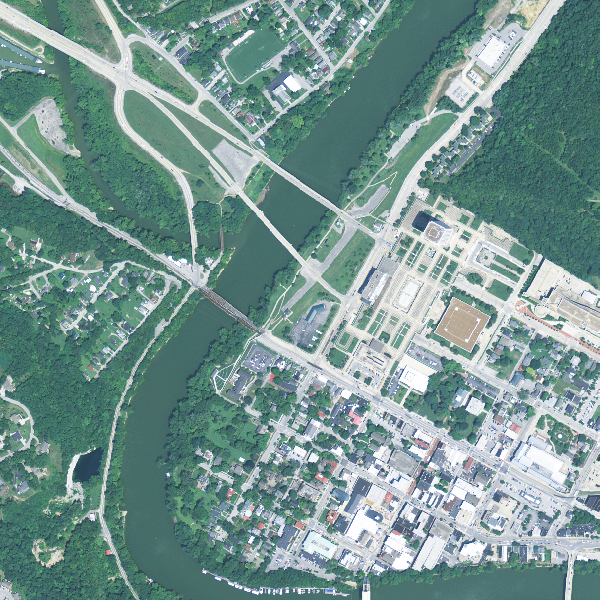

In [9]:
############### Extract image for colorizing and find its bands ###############
rasterParams = {
    # URL to the NAIP image service. Change this to match your lidar time period.
    "input image": r'https://kyraster.ky.gov/arcgis/rest/services/ImageServices/Ky_NAIP_2012_1M/ImageServer',
    # aoi from setAoi function. No need to change this.
    "aoi": aoi,
    # Year of the NAIP image. Change this to match your lidar time period.
    "year": 2020,
    # Image type. Change this if you use a different image type.
    # No spaces or special characters. Use only letters, numbers and underscores.
    # Keep it short too.
    "input image type": "naip",
}

aoi_image = extractImageGetProps(rasterParams)
print(aoi_image)
arcpy.sa.Raster(aoi_image)


In [10]:
# Let's check our project database and folder
checkDatabase()
listContents()

Checking d:\BoydsGIS\_frankfort_p3\_frankfort_p3.gdb database for features and rasters...
Vector layer: aoi
Vector layer: aoilaz
Raster layer: naip_2020
Checking d:\BoydsGIS\_frankfort_p3...
 Volume in drive D is data
 Volume Serial Number is BE8E-8400

 Directory of d:\BoydsGIS\_frankfort_p3

04/24/2025  10:02 AM    <DIR>          .
04/24/2025  10:02 AM    <DIR>          ..
04/24/2025  10:02 AM    <DIR>          extract
04/24/2025  10:02 AM    <DIR>          las
04/24/2025  10:01 AM    <DIR>          laz
04/24/2025  10:02 AM    <DIR>          _frankfort_p3.gdb
04/24/2025  10:02 AM             9,216 _frankfort_p3.lasd
04/24/2025  10:02 AM             9,216 _frankfort_p3_extract_phase1.lasd
               2 File(s)         18,432 bytes
               6 Dir(s)  1,612,611,313,664 bytes free



In [11]:
############### Colorize point cloud ###############
rasterParams = {
    # image from extractImageGetProps function. No need to change this.
    "input image": aoi_image,
    # lasd from createAndExtractLasDataset function. No need to change this.
    "input lasd": extracted_lasd,
    # Bands. Select the red, green and blue bands from properties of the image list above.
    "Red band": "Band_1",
    "Green band": "Band_2",
    "Blue band": "Band_3",
}

colorized_lasd = colorizePointCloud(rasterParams)
print(colorized_lasd)

Process took (2.1s) to complete.
🗸 colorizePointCloud finished processing 2025-04-24 10:02:43.199439
d:\BoydsGIS\_frankfort_p3\_frankfort_p3_colorized_naip_2020_phase1.lasd


### Create a elevation models from LAS dataset

We have generally two elevation models: DEM and DSM. The DEM is the ground elevation and the DSM is the above-ground elevation. To select the type of elevation model, we have to select the correct classification codes for the ground and non-ground points. The default values are `2` for ground and `1` for non-ground. You might want to add other classes or select different returns.

Lists of class codes:

* DSM - Digital Surface Model, select at least `[1, 2]` and other classes as necessary
* DEM - Digital Elevation Model, select `[2]` (and possibly classes representing water).

#### Cells

1. The first cell prints the classes found in the LAS dataset. Use this cell to determine which classes to use for the conversion of the point cloud to a raster.
2. The second cell creates the elevation raster. 
3. The third cell hillshades the raster creating a shaded relief map.

Run the second and third cells to create the elevation models and hillshades. Rerun to create different models and experiment.

**Read the parameter comments carefully** for the best results.

In [31]:
############### Get classification codes from the LASD ###############
lasDatasetStats = {
    # What point cloud do you want to get stats from?
    # Use the colorized point cloud from the previous step.
    "lasd": colorized_lasd
}
getPointCloudStats(lasDatasetStats)

Using d:\BoydsGIS\_frankfort_p1\_frankfort_p1_colorized_naip_2020_phase1.lasd for statisitcs.


Item    Category     Pt_Cnt  Percent   Z_Min    Z_Max  \
9       1_Unclassified  ClassCodes  1349839.0    19.81  453.48   850.52   
10            2_Ground  ClassCodes  1843702.0    27.05  470.97   804.65   
11  7_Low_Point(noise)  ClassCodes     5374.0     0.08  427.65  2008.63   
12             9_Water  ClassCodes   127925.0     1.88  470.63   517.93   
13             10_Rail  ClassCodes     4754.0     0.07  470.92   702.82   
14      17_Bridge_Deck  ClassCodes  1706727.0    25.04  470.74  1227.47   
15       18_High_Noise  ClassCodes  1771290.0    25.99  470.91   804.83   
16         25_Reserved  ClassCodes     5952.0     0.09  470.89   500.99   

    Intensity_Min  Intensity_Max  Synthetic_Pt_Cnt  Range_Min  Range_Max  
9             0.0          255.0               0.0        NaN        NaN  
10            0.0          255.0               0.0        NaN        NaN  
11            0.0          241.0               0.0        NaN        NaN  
12            0.0          255.0               0.0        NaN        NaN  
13            0.0          255.0               0.0        NaN        NaN  
14            0.0          255.0               0.0        NaN        NaN  
15            0.0          255.0               0.0        NaN        NaN  
16            0.0          255.0               0.0        NaN        NaN

Process took (2.1s) to complete.
🗸 rasterizePointCloud finished processing 2025-04-07 18:21:40.307834
dsm_phase1_5ft


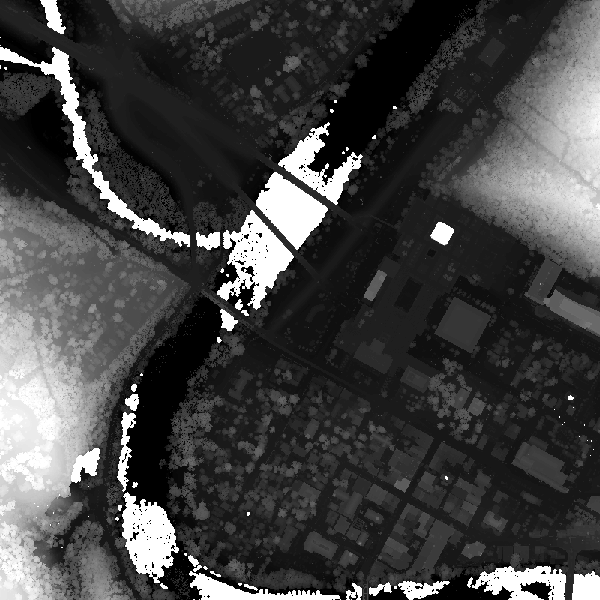

In [45]:

############### Create elevation surface ###############
rasterizeParameters = {
    # What point cloud do you want to get stats from?
    # Use the colorized point cloud from the previous step.
    "lasd": colorized_lasd,
    # What class codes do you want to rasterize? Create a list of class codes.
    # DSM is at least [1, 2]
    # DEM is at least [2]
    "class codes": [1, 2, 9, 17, 25],
    # Returns. Create a list of return numbers. Leave like this for all returns.
    "returns": "#",
    # Type of raster. Select from dsm or dem.
    "type of raster": "dsm",
    # The method to use for sampling. Select from the following:
    # "BINNING MAXIMUM LINEAR", "BINNING AVERAGE LINEAR", "BINNING MINIMUM LINEAR"
    # the first word is the method, the second word is the statistic, the third word is the interpolation
    # Example: "BINNING MAXIMUM LINEAR" calculates the maximum value in each cell using linear interpolation
    # It's good for DSM.
    # Example: "BINNING AVERAGE LINEAR" calculates the average value in each cell using linear interpolation
    # It's good for DEM.
    # "sampling method": "TRIANGULATION",
    "sampling method": "BINNING MAXIMUM SIMPLE",
    # Cell resolution in feet. Change this to match your project requirements.
    # Phase 1 lidar is 5 feet resolution. Phase 2 lidar is 2 feet resolution.
    # Never go below these values for the phases otherwise artifacts will appear.
    "cell resolution": 5,
}

aoi_elevation = rasterizePointCloud(rasterizeParameters)
print(aoi_elevation)
arcpy.sa.Raster(aoi_elevation)

In [ ]:
############### Create hillshade, aka shaded relief ###############
hillshadeParameters = {
    # What elevation raster do you want to use?
    # Use the elevation raster from the previous step.
    "elevation raster": aoi_elevation,
    # Azimuth of the light source. 0 is from the north, 90 is from the east, 180 is from the south, 270 is from the west.
    "azimuth": 270,
    # Altitude of the light source. 0 is at the horizon, 90 is directly above
    "altitude": 50,
    # Cast shadows? Set to True to cast shadows but the image will be darker.
    "shadows": False,
    # Z factor. Vertical exaggeration. 1 is no exaggeration.
    "zFactor": 1,
}

aoi_hillshade = hillshadePointCloud(hillshadeParameters)
print(aoi_hillshade)
arcpy.sa.Raster(aoi_hillshade)

In [ ]:
# Let's see if you have the new rasters in the database and new project properties
helloDictionary(projectTemplate)
checkDatabase()

### Export for web platforms and visualization

The *tools* folder has two PotreeConverter versions. Version 2 is the current version, but it produces files that are too large to be hosted on GitHub Pages. 

Use Potree version 1 if you plan to host tiles on GitHub Pages.

<!-- ![Point cloud viewer](https://nyc3.digitaloceanspaces.com/astoria/geo409/images/add-image-potree.jpg)    
*Potree point cloud viewer* -->

#### Cells

1. Merge the LAS files that were created for colorization. This creates a single LAS file that can be uploaded to web platforms like Cesium Ion for visualization.
2. Create a Potree point cloud viewer and necessary files in a folder called `viewer` in your project folder. The viewer can be hosted on a web server or uploaded to a web platform like GitHub Pages.

In [12]:
############### Merge LAS tiles into a single LAS file ###############
mergeParameters = {
    # The folder in the project that contains the colorized point clouds.
    # Should be 'colorized' if you followed the steps above.
    "input folder": "colorized",
    # The classes that you'll keep. Create a string of class codes separated by a space.
    # 1 2 is a good start for DSM.
    "keep class codes": "1, 2, 17",
}

mergedLas = mergeLas(mergeParameters)
print(mergedLas)

Process took (0.9s) to complete.
🗸 mergeLas finished processing 2025-04-24 10:02:59.173971
d:\BoydsGIS\_frankfort_p3\merged\_frankfort_p3_phase1_merged.las


In [14]:
############### Make a Potree point cloud viewer for the Browser ###############
potreeParameters = {
    # The output from the mergeLas function. No need to change this.
    'input merged las name': mergedLas,
    # The potree viewer version. Use 1 for now.
    "potree version": 1,
}

potreeViewer = makeViewer(potreeParameters)
print(potreeViewer)

Process took (7.4s) to complete.
🗸 makeViewer finished processing 2025-04-24 10:04:11.787275
d:\BoydsGIS\_frankfort_p3\viewer


### Clean up after colorization

After you have successfully created a colorized point cloud, you can start removing redundant data. **Verify that you have a colorized point cloud before deleting directories**. 

The following directories are no longer needed:
1. *laz* - contains the LAZ files
2. *las* - contains the LAS files
3. *extract* - contains the uncolorized, extracted LAS files

That should reduce the project size substantially (by about 75%). To keep the minimum assets from this project, backup: the merged LAS file and the geodatabase.

This is the end of data processing. Go back to the lesson documentation to create a map layout and 3D animation of your point cloud.